Falso. Pois os imóveis com vista para água são 3x mais valorizados que os imóveis sem vista para água. Evidenciando, que a compra de imóveis com vista para água é lucrativo
Falso. Pouco muda os valores dos imóveis que foram construídos antes e depois de 1955
Falso. Os imóveis sem porão, possuem área maior que os imóveis com porão, porém 20% em média
Falso. De 2014 para 2015, houve uma queda nos preços dos imóveis
Falso. O gráfico varia com crescimentos e decaimentos. Os meses de janeiro, fevereiro, e novembro, são bons meses para compra de imóveis com 3 banheiro e os meses abril, maio e junho, são os melhores para venda
Falso. Casas em bom estado são 62% mais caras. É lucrativo, comprar casas em condições ruins e vender em boas condições
Verdeiro. As casas que ja foram reformadas pelo menos uma vez, tem um aumento de 40% preço, reafirmando que o negócio de compra/reformar/venda é lucrativo
 Verdade. As casas que possuem porão são 30% mais caras, invista em casa com porão abaixo da médi

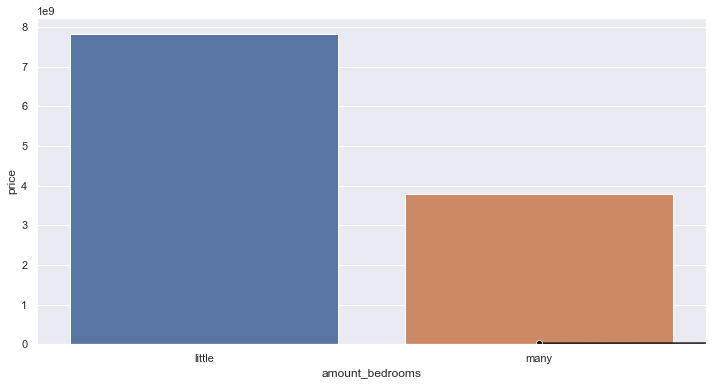

In [55]:
import numpy          as np
import pandas         as pd 
import seaborn        as sns
import ipywidgets     as widgets
import plotly.express as px

from matplotlib           import gridspec
from ipywidgets           import interact, interactive, fixed, interact_manual
from IPython.core.display import HTML

from matplotlib           import pyplot as plt

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

def get_data(path): #função para carregar os dados coletados
    
    data = pd.read_csv(path)
    
    return data

def analysis_data(data):  #função para gerar analises, com o intuito de retirar dados com erro e duplicados. 
    
    data_types = data.dtypes 
    data_na = data.isna().sum()
    data_describe = data.describe().T
    data_duplicates = len(data) - data["id"].nunique()
    
    return data_types, data_na, data_describe, data_duplicates #retorna os datasets para análise 

def clear_data (data): #função para limpar o dataset baseado nas análises 
    data_clear = data.dropna(subset=['id'])   
    data_clear = data_clear.drop_duplicates(subset='id', keep ='last').reset_index(drop=True)
    data_clear = data_clear.drop(15870)
    data_clear['date'] = pd.to_datetime(data_clear['date'], format = '%Y-%m-%d')
    
    return data_clear #retorna o dataset limpo

def transform_data (data_cleaned): #função para realizar as transformações necessárias para serem feitas as manipulçãoes.

    data_cleaned['month'] = data_cleaned['date'].dt.month
    data_cleaned['year'] = data_cleaned['date'].dt.year
    
    data_cleaned['season'] = data_cleaned['month'].apply(lambda x: 'spring' if (x >=3) & (x<=5) else 
                                               'summer' if (x >=  6) & (x <= 8) else
                                               'fall' if (x >= 9 ) & (x <= 11) else
                                               'winter')
    data_cleaned['yr_old'] = data_cleaned['yr_built'].apply (lambda x: 'old' if (x <= 1955) else 'new')
    data_cleaned['basement'] = data_cleaned['sqft_basement'].apply(lambda x: 'yes' if (x != 0) else 'no')
    data_cleaned['state'] = data_cleaned['condition'].apply(lambda x: 'good' if (x>=3) else 'bad')
    data_cleaned['remodeling'] = data_cleaned['yr_renovated'].apply(lambda x: 'yes' if (x!=0) else 'no')
    data_cleaned['view_condition'] = data_cleaned['view'].apply(lambda x: 'good'if (x>=2) else 'bad')
    data_cleaned['amount_bedrooms'] = data_cleaned['bedrooms'].apply(lambda x: 'many' if (x>=3) else 'little')
    
    return data_cleaned #retorna o dataset modelado. 

def buy_data (data_transformed): #função para determinar as casas que devem ser compradas(baseado nos preços abaixo da mediana)
    
    resp01 = data_transformed.dropna(subset=['id'])
    
    price_median = data[['zipcode','price']].groupby('zipcode').median().reset_index()
    
    resp01 = pd.merge(resp01, price_median, on='zipcode', how='inner')
    
    for i in range (len(resp01)):
        if ((resp01.loc[i, 'price_x'] < resp01.loc[i,'price_y']) & (resp01.loc[i,'condition'] > 2)):
            resp01.loc[i,'status'] = 'compra'
        else:
            resp01.loc[i,'status'] = 'nao_compra'
            
    resp01.rename(columns={'price_x': 'price'}, inplace = True)
    resp01.rename(columns={'price_y': 'price_mediana'}, inplace = True)
    
    resp01 = resp01[['id','zipcode','season','price','price_mediana','condition','lat','long','view_condition','basement','bathrooms','bedrooms','status']].copy()
    
    return resp01 #retorna dataset com as a coluna 'status', separando casas com recomendações de compra ou não compra. 

def sale_data(data_buy): #função que recebe o dataset com a coluna status para determinar quando devem ser vendidas as casas.
    resp02 = data_buy.dropna(subset=['id'])
    
    resp02 = resp02[resp02['status']== 'compra'].copy()
    
    price_median2 = resp02[['price','zipcode','season']].groupby(['zipcode', 'season']).median('price').reset_index()

    resp02 = pd.merge(resp02, price_median2, on=['zipcode','season'], how='inner')
    
    for i in range(len(resp02)):
        resp02.loc[i, 'seasonality'] = 1.3 if (resp02.loc[i, 'price_x'] < resp02.loc[i, 'price_y']) else 1.1
    
    for i in range(len(resp02)):
        resp02.loc[i,'price_sell'] = resp02.loc[i,'price_x']*resp02.loc[i,'seasonality']
        resp02.loc[i,'profit'] = resp02.loc[i,'price_sell'] - resp02.loc[i,'price_x']
            
    resp02.rename(columns={'price_x': 'price'}, inplace = True)
    resp02.rename(columns={'price_y': 'price_median_season'}, inplace = True)
    
    resp02 = resp02[['id','zipcode','season','price_median_season','price','price_sell','profit']].copy()
    
    return resp02 #retorna o dataset com o preço a ser vendido, periódo de venda e lucro sobre a venda. 

# Hipotese 1 - Imóveis que possuem vista para água, são 30% mais caros na media.
def hypotheses_1 (data_transformed):
    
    house_waterfront = data_transformed[['price','waterfront']].groupby('waterfront').mean().reset_index()
    hip1 = sns.barplot(y = house_waterfront['price'], x = house_waterfront['waterfront']);
    
    print(f'Falso. Pois os imóveis com vista para água são 3x mais valorizados que os imóveis sem vista para água. Evidenciando, que a compra de imóveis com vista para água é lucrativo')
    
    return hip1

# Hipotese 2 - Imóveis com data de construção menor que 1955, são 50% mais baratas, na média.
def hypotheses_2 (data_transformed):
    
    yr_old = data_transformed[['price','yr_old']].groupby('yr_old').mean().reset_index()
    hip2 = sns.barplot(y = yr_old['price'], x = yr_old['yr_old']);
    
    print(f'Falso. Pouco muda os valores dos imóveis que foram construídos antes e depois de 1955')
    
    return hip2

# Hipotese 3 - Imóveis sem porão possuem área total 40% maiores do que os imóveis com porão 
def hypotheses_3 (data_transformed):
    
    basement_area = data_transformed[['sqft_lot','basement']].groupby('basement').mean().reset_index()
    hip3 = sns.barplot(y = basement_area['sqft_lot'], x = basement_area['basement']);
    
    print(f'Falso. Os imóveis sem porão, possuem área maior que os imóveis com porão, porém 20% em média')
          
    return hip3

# Hipotese 4 - O crescimento do preço dos imóveis YoY é de 10%
def hypotheses_4 (data_transformed):
    
    yoy = data_transformed[['price','year']].groupby('year').sum().reset_index()
    hip4 = sns.barplot(y=yoy['price'],x=yoy['year']);
    
    print(f'Falso. De 2014 para 2015, houve uma queda nos preços dos imóveis')
    
    return hip4

# Hipotese 5 - Imóveis com 3 banheiros tem um crescimento de preço MoM de 15%
def hypotheses_5 (data_transformed):
    
    bathrooms_price = data_transformed[['month','price','bathrooms']].groupby(['month', 'bathrooms']).sum('price').reset_index()
    bathrooms_price2 = bathrooms_price[bathrooms_price.bathrooms ==3]
    hip5 = sns.lineplot(y=bathrooms_price2.price, x= bathrooms_price2.month, color = 'black', markers = True, style = (1), legend = False);
    
    print(f'Falso. O gráfico varia com crescimentos e decaimentos. Os meses de janeiro, fevereiro, e novembro, são bons meses para compra de imóveis com 3 banheiro e os meses abril, maio e junho, são os melhores para venda')
    
    return hip5

#Hipoteses 6 - Imóveis com condições boas (3 ou mais), são 30% mais caros, na média
def hypotheses_6 (data_transformed):
    
    state_houses = data_transformed[['price','state']].groupby('state').mean().reset_index()
    hip6 = sns.barplot(y=state_houses['price'],x=state_houses['state']);
    
    print(f'Falso. Casas em bom estado são 62% mais caras. É lucrativo, comprar casas em condições ruins e vender em boas condições')
    
    return hip6

#Hipotese 7 - Imóveis que já tiveram pelo menos uma reforma, são 40% mais caros, na média.
def hypotheses_7 (data_transformed):
    
    remodeling_houses = data_transformed[['price', 'remodeling']].groupby('remodeling').mean().reset_index()
    hip7 = sns.barplot(y=remodeling_houses['price'], x=remodeling_houses['remodeling']);
    
    print(f'Verdeiro. As casas que ja foram reformadas pelo menos uma vez, tem um aumento de 40% preço, reafirmando que o negócio de compra/reformar/venda é lucrativo')
    
    return hip7

#Hipotese 8 - Casas com porão, são 30% mais caras que as casam sem porão, em média
def hypotheses_8 (data_transformed):
    
    basement_price = data_transformed[['price', 'basement']].groupby('basement').mean().reset_index()
    hip8 = sns.barplot(y=basement_price['price'], x=basement_price['basement']);
    
    print(f' Verdade. As casas que possuem porão são 30% mais caras, invista em casa com porão abaixo da média de preços')
    
    return hip8

#Hipotese 9 - Casa com boa vista, são 30% mais caras que as casam que não possuem, em média.
def hypotheses_9 (data_transformed):
    
    view_good = data_transformed[['price','view_condition']].groupby('view_condition').mean().reset_index() 
    hip9 = sns.barplot(y=view_good['price'], x=view_good['view_condition']);
    
    print(f' Falso. Casa com boa vista são quase o dobro (91%) do preço das casas com vista ruim, investir em casas com boa vista, abaixo da média, sao lucrativas')
    
    return hip9

#Hipotese 10  - Imóveis com 3 quartos ou mais, são 40% mais caros que os imóveis com menos, em média. 
def hypotheses_10 (data_transformed):
    
    bedrooms_houses = data_transformed[['price','amount_bedrooms']].groupby('amount_bedrooms').mean().reset_index()
    hip10 = sns.barplot(y=bedrooms_houses['price'], x=bedrooms_houses['amount_bedrooms']);
    
    print(f'Verdade. Investir em casas com mais quartos e que estão abaixo da média, é lucrativo')
    
    return hip10

if __name__ == "__main__":
    # ETL
    path = r'C:\Users\diego\OneDrive\Área de Trabalho\Comunidade DS\repos\Python do zero ao ds\kc_house_data.csv\kc_house_data.csv'

    # load data
    data = get_data(path)
    analysis_data(data)

    # transform data
    data_cleaned = clear_data(data) 
    data_transformed = transform_data (data_cleaned)

    #carge data
    data_buy = buy_data(data_transformed)
    data_sale = sale_data(data_buy)
    
    hypotheses_1(data_transformed)
    hypotheses_2(data_transformed)
    hypotheses_3(data_transformed)
    hypotheses_4(data_transformed)
    hypotheses_5(data_transformed)
    hypotheses_6(data_transformed)
    hypotheses_7(data_transformed)
    hypotheses_8(data_transformed)
    hypotheses_9(data_transformed)
    hypotheses_10(data_transformed)

In [56]:
data_buy

,id,zipcode,season,price,price_mediana,condition,lat,long,view_condition,basement,bathrooms,bedrooms,status
0,7129300520,98178,fall,221900.00,278277.00,3,47.51,-122.26,bad,no,1.00,3,compra
1,4060000240,98178,summer,205425.00,278277.00,4,47.50,-122.25,bad,no,1.00,2,compra
2,4058801670,98178,summer,445000.00,278277.00,3,47.51,-122.24,good,yes,2.25,3,nao_compra
3,2976800796,98178,fall,236000.00,278277.00,3,47.51,-122.25,bad,no,1.00,3,compra
4,6874200960,98178,winter,170000.00,278277.00,3,47.50,-122.27,bad,no,1.00,2,compra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21430,2525049086,98039,fall,2720000.00,1892500.00,4,47.62,-122.23,bad,no,3.25,4,nao_compra
21431,2525049113,98039,summer,1950000.00,1892500.00,4,47.62,-122.24,bad,no,3.50,4,nao_compra
21432,3262300485,98039,spring,2250000.00,1892500.00,3,47.63,-122.24,bad,no,5.25,5,nao_compra
21433,6447300365,98039,fall,2900000.00,1892500.00,3,47.61,-122.22,bad,no,4.00,5,nao_compra


Falso. O gráfico varia com crescimentos e decaimentos. Os meses de janeiro, fevereiro, e novembro, são bons meses para compra de imóveis com 3 banheiro e os meses abril, maio e junho, são os melhores para venda


<AxesSubplot:xlabel='month', ylabel='price'>

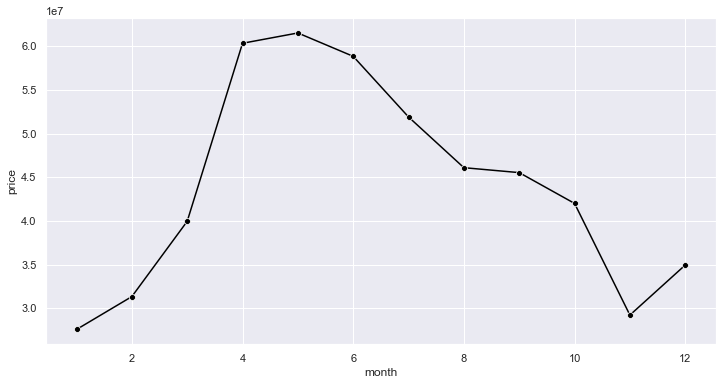

In [59]:
hypotheses_5(data_transformed)

Verdade. Investir em casas com mais quartos e que estão abaixo da média, é lucrativo


<AxesSubplot:xlabel='amount_bedrooms', ylabel='price'>

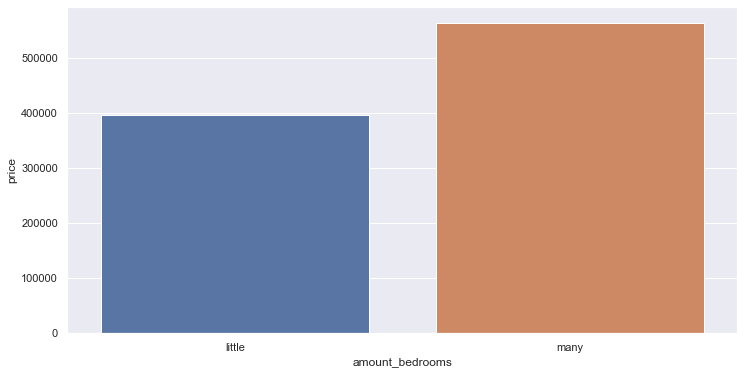

In [58]:
hypotheses_10(data_transformed)